In [2]:
import sys
sys.path.append("..")

import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import importlib
import utils
importlib.reload(utils);
from utils import *
from termcolor import colored
from tensorflow.keras import layers, Model, Input #type: ignore

In [3]:
csv_path  = '../data/list_eval_partition.csv'
bbox_path = '../data/bbox_celeba.csv'
image_dir = '../data/img_align_celeba/img_align_celeba/'
BATCH_SIZE = 64

df_partition = pd.read_csv(csv_path)
df_data = pd.read_csv(bbox_path)
df = pd.merge(df_data, df_partition, on='image_id')
df = df[df["face_detected"] == 1].drop(columns=["face_detected"])

df_train = df[df["partition"] == 0].drop(columns=["partition"])
df_val = df[df["partition"] == 1].drop(columns=["partition"])
df_test = df[df["partition"] == 2].drop(columns=["partition"])

train_ds = make_image_dataset(df_train,image_dir,img_size=(64,64),batch_size=BATCH_SIZE,shuffle=True)
val_ds = make_image_dataset(df_val,image_dir,img_size=(64,64),batch_size=BATCH_SIZE)
test_ds = make_image_dataset(df_test,image_dir,img_size=(64,64),batch_size=BATCH_SIZE)


## Definicja modelu


In [4]:
BATCH_SIZE = 64
latent_dim = 256

In [5]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        #batch = tf.shape(z_mean)[0]
        #dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(BATCH_SIZE, latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder,beta=0.1, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return z_mean,z_log_var,reconstructed
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstructed = self(data)

            kl_loss = -0.5 * tf.reduce_mean(
                z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
            )
            reconstruction_loss = tf.reduce_mean(
                    #tf.keras.losses.binary_crossentropy(data, reconstructed)
                    tf.keras.losses.MeanSquaredError()(data,reconstructed)
                    
            )
            total_loss = self.beta * kl_loss + reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss":total_loss,"kl_loss": kl_loss, "reconstruction_loss": reconstruction_loss}
    def test_step(self,data):
        z_mean, z_log_var, reconstructed = self(data)
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        reconstruction_loss = tf.reduce_mean(
            #tf.keras.losses.binary_crossentropy(data, reconstructed)
            tf.keras.losses.MeanSquaredError()(data,reconstructed)
        )
        total_loss = self.beta * kl_loss + reconstruction_loss
        return {"loss":total_loss,"kl_loss": kl_loss, "reconstruction_loss": reconstruction_loss}

In [7]:
print(colored("Encoder:","red"))
encoder_inputs = Input(shape=(64, 64, 3), name="encoder_input")  
x = layers.Conv2D(32, kernel_size=5, strides=2, padding="same", activation="relu")(encoder_inputs)
#x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
#x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, kernel_size=3, strides=1, padding="same", activation="relu")(x)
#x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
#x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
z_mean    = layers.Dense(latent_dim, name="z_mean")(x)      
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean,z_log_var,z], name="encoder")
z_predict = encoder.predict(train_ds.take(1))
print(colored("Test prediction shape of 1 batch:","blue"),z_predict[0].shape)

print(colored("Decoder:","red"))
decoder_input = Input(shape=(latent_dim,), name="z_input")
x = layers.Dense(8 * 8 * latent_dim, activation="relu")(decoder_input)
x = layers.Reshape((8, 8, latent_dim))(x)
x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64,  kernel_size=3, strides=1, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64,  kernel_size=3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32,  kernel_size=5, strides=2, padding="same", activation="relu")(x)
decoder_output = layers.Conv2DTranspose(
        3, kernel_size=3, strides=1, padding="same", activation="sigmoid", name="decoder_output")(x)
decoder = Model(decoder_input, decoder_output, name="conv_decoder")
predict = decoder.predict(z_predict[2])
print(colored("Test prediction shape of 1 batch:","blue"),predict.shape)

Encoder:

1/1 [==============================] - 0s 238ms/step
Test prediction shape of 1 batch: (64, 256)
Decoder:
2/2 [==============================] - 0s 26ms/step
Test prediction shape of 1 batch: (64, 64, 64, 3)


In [8]:
vae = VAE(encoder, decoder,beta=0.05)
initial_learning_rate = 5e-3
decay_steps = 8*2543
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=decay_steps,
                decay_rate=0.98,
                staircase=False)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    start_from_epoch=10,
    patience=5,
    restore_best_weights=True,
    verbose=1,
)

vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))
history = vae.fit(train_ds, epochs=60, validation_data=val_ds,verbose=1,callbacks=[early_stopping])

vae.save_weights('vae_weights.h5')

Epoch 1/60
  49/2418 [..............................] - ETA: 9:36 - loss: 0.0587 - kl_loss: 2.7459e-04 - reconstruction_loss: 0.0586

KeyboardInterrupt: 

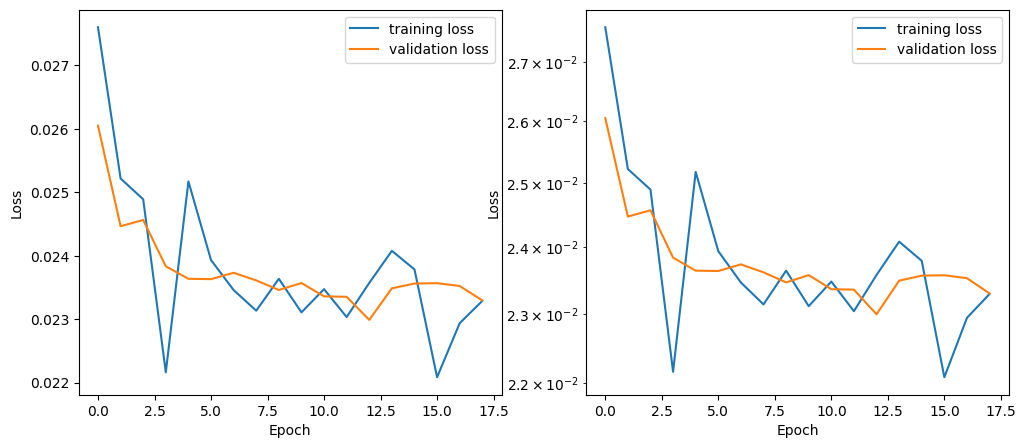

In [51]:
plotHistory(history=history,validation=True)
plt.savefig("vae_loss.png")
plt.show()

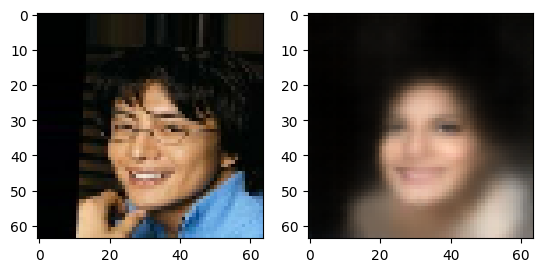

In [59]:
example = next(iter(train_ds))

output = vae(example)[2][0]

fig,axes = plt.subplots(1,2)
pil_img = tf.keras.preprocessing.image.array_to_img(example[0].numpy())
axes[0].imshow(pil_img)
pil_img = tf.keras.preprocessing.image.array_to_img(output.numpy())
axes[1].imshow(pil_img)
plt.show()


### Saving model
 

In [ ]:
# PIERWSZY SPOSÓB

# save
vae.save_weights('vae_weights.h5')

# load
vae2 = VAE(encoder, decoder,beta=0.05)
vae2.build((None, 64, 64, 3))
vae2.load_weights('vae_weights.h5')

<tf.Tensor: shape=(64, 64, 3), dtype=float32, numpy=
array([[[0.50108767, 0.49503258, 0.49094608],
        [0.50657016, 0.4930117 , 0.481823  ],
        [0.5034482 , 0.4923434 , 0.48185512],
        ...,
        [0.5105349 , 0.490677  , 0.4730763 ],
        [0.5090126 , 0.4890437 , 0.47397766],
        [0.51062584, 0.49081245, 0.47596166]],

       [[0.4970141 , 0.4876877 , 0.48664984],
        [0.49972323, 0.47654802, 0.47280368],
        [0.49600512, 0.4770193 , 0.47043723],
        ...,
        [0.49822742, 0.46860015, 0.452758  ],
        [0.49932963, 0.47413024, 0.45344096],
        [0.5038527 , 0.48097506, 0.46282318]],

       [[0.49780563, 0.48276046, 0.4837047 ],
        [0.5062412 , 0.4705586 , 0.46982542],
        [0.504057  , 0.4650189 , 0.4650655 ],
        ...,
        [0.50899875, 0.44414333, 0.44180077],
        [0.5148972 , 0.44665483, 0.4498413 ],
        [0.5078462 , 0.46720034, 0.45454934]],

       ...,

       [[0.49522206, 0.4804986 , 0.4832938 ],
        [0.5030

In [ ]:
# DRUGI SPOSÓB

#save
vae.save("vae_model", save_format="tf")

#load - not sure if working
from tensorflow.keras.models import load_model
custom_objects = {"Sampling": Sampling, "VAE": VAE}
vae_loaded = load_model("vae_model", custom_objects=custom_objects)